## Import Library yang dibutuhkan

In [1]:
import torch, detectron2
import sys, os, distutils.core
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/home/mal/miniconda3/envs/dtc2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  1.13 ; cuda:  cu117
detectron2: 0.6


In [2]:
# Setup dtc2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import library umum
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import dtc2 utility
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

%matplotlib inline

## Inisialisasi Dataset (format COCO JSON)

In [34]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "dataset/Kav1/Kav1_coco.json", "dataset/Kav1")
register_coco_instances("my_dataset_val", {}, "dataset/Kav2/Kav2_coco.json", "dataset/Kav2")

Verifikasi dataset yang diregister

[12/18 17:28:35 d2.data.datasets.coco]: Loaded 1 images in COCO format from dataset/Kav1/Kav1_coco.json
(2357, 2357, 3)


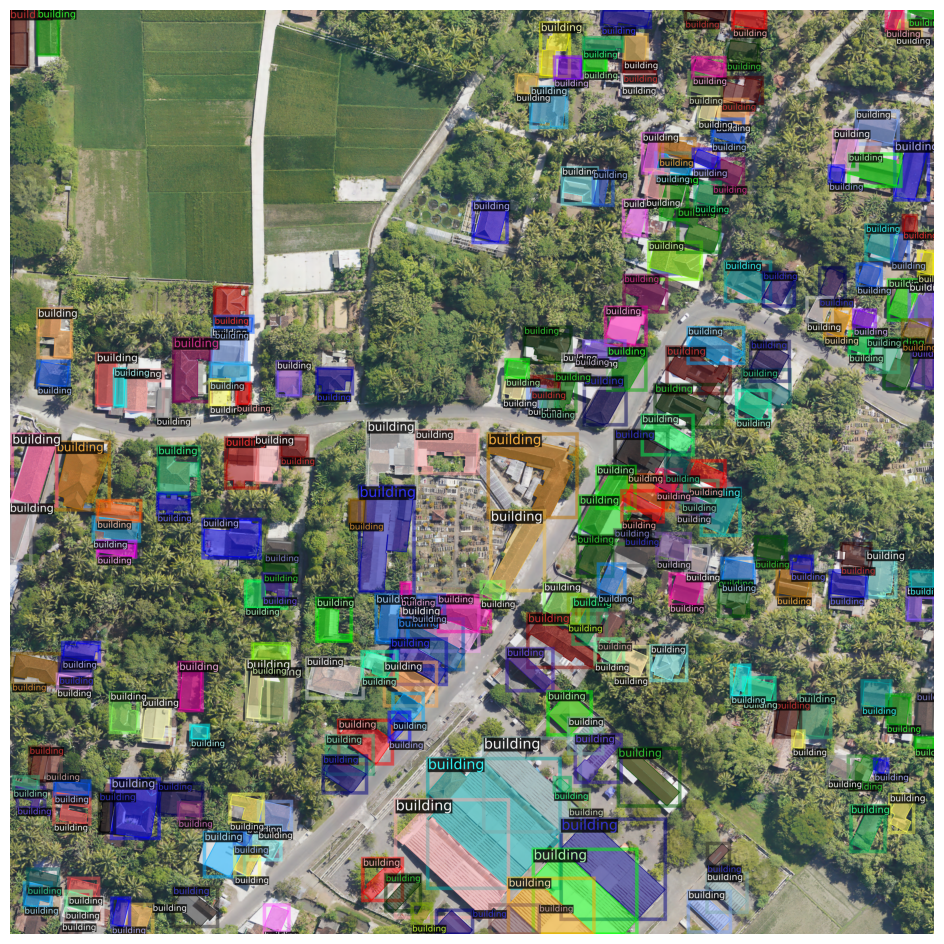

[12/18 17:28:39 d2.data.datasets.coco]: Loaded 1 images in COCO format from dataset/Kav2/Kav2_coco.json
(2357, 2357, 3)


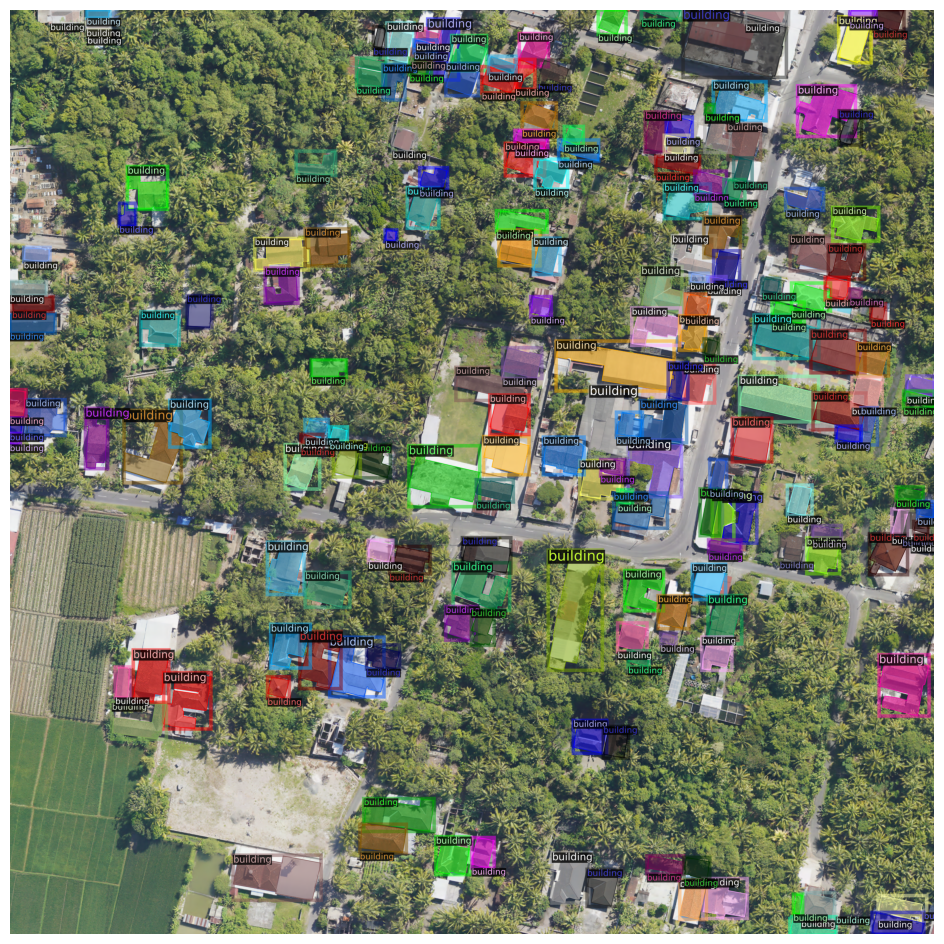

In [41]:
dataset_names = ["my_dataset_train", "my_dataset_val"]

for dataset_name in dataset_names:
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)

    # Choose a random index
    random_index = random.randint(0, len(dataset_dicts) - 1)
    random_sample = dataset_dicts[random_index]

    img = cv2.imread(random_sample["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=2)
    vis = visualizer.draw_dataset_dict(random_sample)

    # Display using matplotlib
    plt.figure(figsize=(12,12))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

## Training Model

In [33]:
# from detectron2.engine import DefaultTrainer

# cfg = get_cfg()
# # cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("my_dataset_train",)
# cfg.DATASETS.TEST = ()
# cfg.DATALOADER.NUM_WORKERS = 2
# # cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
# cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
# cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
# cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
# cfg.SOLVER.STEPS = []        # do not decay learning rate
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

[12/18 17:04:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[12/18 17:04:12 d2.engine.train_loop]: Starting training from iteration 0
[12/18 17:04:26 d2.utils.events]:  eta: 0:11:25  iter: 19  total_loss: 2.427  loss_cls: 0.6357  loss_box_reg: 0.2748  loss_mask: 0.6841  loss_rpn_cls: 0.4051  loss_rpn_loc: 0.4234    time: 0.7088  last_time: 0.5956  data_time: 0.0321  last_data_time: 0.0080   lr: 0.00019981  max_mem: 3014M
[12/18 17:04:41 d2.utils.events]:  eta: 0:11:36  iter: 39  total_loss: 2.292  loss_cls: 0.5332  loss_box_reg: 0.5204  loss_mask: 0.6112  loss_rpn_cls: 0.2473  loss_rpn_loc: 0.3602    time: 0.7270  last_time: 0.7993  data_time: 0.0067  last_data_time: 0.0066   lr: 0.00039961  max_mem: 3014M
[12/18 17:04:56 d2.utils.events]:  eta: 0:11:23  iter: 59  total_loss: 2.062  loss_cls: 0.5081  loss_box_reg: 0.5577  loss_mask: 0.4999  loss_rpn_cls: 0.1673  loss_rpn_loc: 0.3228    time: 0.7277  last_time: 0.8026  data_time: 0.0064  last_data_time: 0.0048   lr: 0.00059941  max_mem: 3014M
[12/18 17:05:11 d2.utils.events]:  eta: 0:11:09  iter

## Cek Statistik training di tensorboard

In [32]:
%load_ext tensorboard
%tensorboard --logdir output

## Evaluasi Training

In [35]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/18 17:22:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


[12/18 17:24:11 d2.data.datasets.coco]: Loaded 1 images in COCO format from dataset/Kav2/Kav2_coco.json


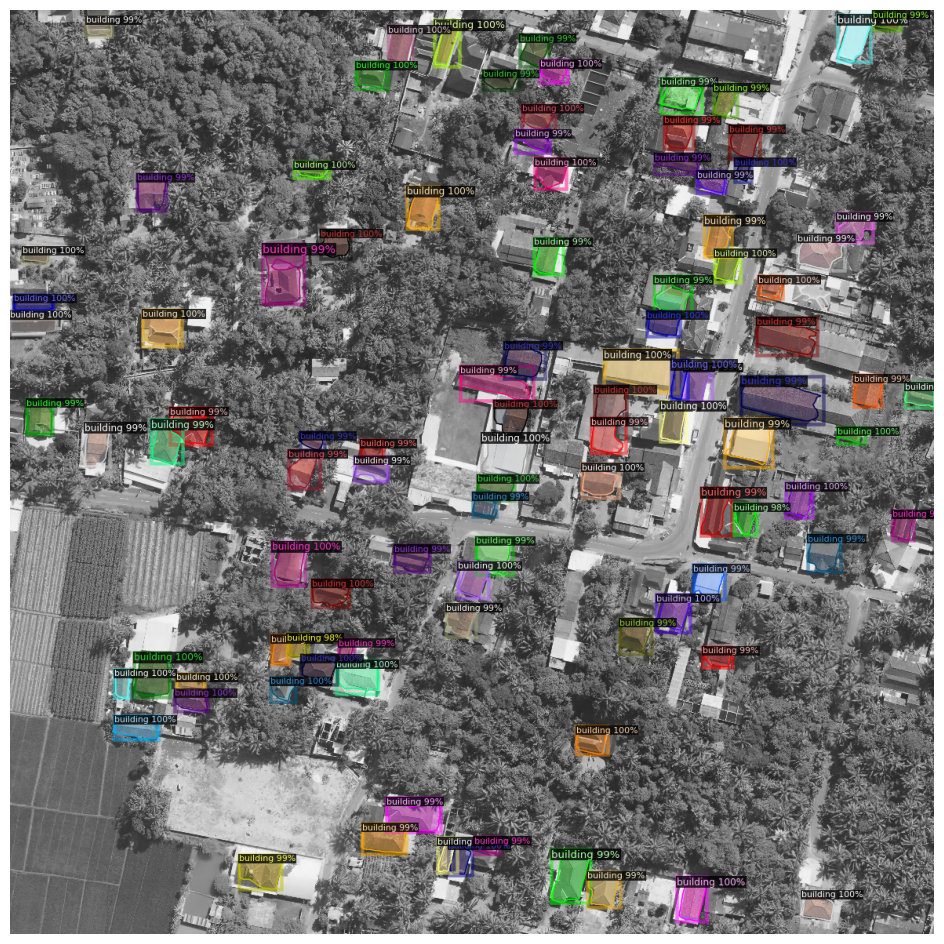

In [38]:
dataset_dicts = DatasetCatalog.get('my_dataset_val')
metadata = MetadataCatalog.get(dataset_name)

# Choose a random index
# random_index = random.randint(0, len(dataset_dicts) - 1)
random_sample = dataset_dicts[0]

im = cv2.imread(random_sample["file_name"])
outputs = predictor(im)

v = Visualizer(
    im[:, :, ::-1],
    metadata=metadata,
    scale=0.5,
    instance_mode=ColorMode.IMAGE_BW  # remove the colors of unsegmented pixels
)

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
# Display using matplotlib
plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axis labels and ticks
plt.show()

In [39]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[12/18 17:28:08 d2.data.datasets.coco]: Loaded 1 images in COCO format from dataset/Kav2/Kav2_coco.json
[12/18 17:28:08 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  building  | 191          |
|            |              |
[12/18 17:28:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/18 17:28:08 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/18 17:28:08 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[12/18 17:28:08 d2.data.common]: Serialized dataset takes 0.05 MiB
[12/18 17:28:08 d2.evaluation.evaluator]: Start inference on 1 batches
[12/18 17:28:10 d2.evaluation.evaluator]: Inference done 1/1. Dataloading: 0.0000 s/iter. Inference: 0.3304 s/iter. Eval: 1.1547 s/iter. Total: 1.4851 s/ite